Učitavanje potrebnih biblioteka

In [1]:
import os
import math
import scipy as sc
import numpy as np
import scipy as sp
import pandas as pd
import ujson as json
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from statistics import mean
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

ZIP datoteka sadrži:

- uvjete korištenja u datoteci LICENSE.TXT

- datoteku samples_by_label.txt koja sadrži podatke formata:
ime_datototeke,oznaka
pri čemu je svaka datoteka jedan uzorak a oznaka 1 označuje da je datoteka pakirana dok oznaka 0 označuje da nije pakirana

- datoteku samples_by_packer_group.txt koja sadrži podatke formata:
ime_datoteke,broj_grupe
pri čeku je svaka datoteka jedan uzorak, oznaka 0 označuje da datoteka nije pakirana dok oznake 1-4 označuju jednu od četiri grupe pakiranih datoteka (prema vrsti pakiranja)

- uzorke u direktoriju samples (svaki uzorak jedna datoteka, smještena u poddirektorij koji nosi ime po zadnja dva znaka njenog imena)

- za svaki uzorak u direktoriju samples, u direktoriju reports nalazi se pripadajući TitaniumCore izvještaj u JSON formatu, pri čemu se izvještaj za datoteku zove po imenu uzorka, uz ekstenziju ".json". Izvještaji su smješteni u poddirektorije koji nose ime po zadnja dva znaka imena uzorka.

Učitavanje shas i group

In [2]:
shas, groups = zip(*[x.split(',') for x in open('samples_by_packer_group.txt').read().splitlines()])
sha_group = {a: int(b) for a, b in zip(shas, groups)}
sha_label = {a: 1 if int(b) else 0 for a, b in zip(shas, groups)}
shas = list(sha_label.keys())

Učitavanje podataka

In [3]:
# Extracting data from TC report
Data={}

sha_value=[]
target=[]
Data['sha']=sha_value
Data['target']=target

# from [Info][file]
fileSize=[]
fileEntropy=[]

Data['fileSize']=fileSize;
Data['fileEntropy']=fileEntropy


# from [metadata][application][pe][dosHeader]
eCBLp=[]
eCP=[]
eCRIc=[]
eCParHdr=[]
eSS=[]
eSP=[]
eCsum=[]
eIP=[]
eCS=[]
eLFARIc=[]
eOvNo=[]
eLFANew=[]

Data['eCBLp']=eCBLp
Data['eCP']=eCP
Data['eCParHdr']=eCParHdr
Data['eSS']=eSS
Data['eSP']=eSP
Data['eCsum']=eCsum
Data['eIP']=eIP
Data['eCS']=eCS
Data['eOvNo']=eOvNo
Data['eLFANew']=eLFANew


# from [metadata][application][pe][fileHeader]
numberOfSections=[]
sizeOfOptionalHeaders=[]

Data['numberOfSections']=numberOfSections
Data['sizeOfOptionalHeaders']=sizeOfOptionalHeaders

# from [metadata][application][pe][fileHeader][characteristics]
characteristic_list=[]


# from [metadata][application][pe][optionalHeader]
majorLinkerVersion=[]
minorLinkerVersion=[]
sizeOfCode=[]
sizeOfInitializedData=[]
sizeOfUninitializedData=[]
addressOfEntryPoint=[]
imageBase=[] 
sectionAlignment=[]
fileAlignment=[]
sizeOfImage=[]
sizeOfHeaders=[]
sizeOfStackCommit=[]
sizeOfStackReserve=[]
sizeOfHeapCommit=[]
sizeOfHeapReserve=[]
loaderFlags=[]
numberOfRvaAndSizes=[]
checksum=[]


Data['majorLinkerVersion']=majorLinkerVersion
Data['minorLinkerVersion']=minorLinkerVersion
Data['sizeOfCode']=sizeOfCode
Data['sizeOfInitializedData']=sizeOfInitializedData
Data['sizeOfUninitializedData']=sizeOfUninitializedData
Data['addressOfEntryPoint']=addressOfEntryPoint
Data['imageBase']=imageBase
Data['sectionAlignment']=sectionAlignment
Data['fileAlignment']=fileAlignment
Data['sizeOfImage']=sizeOfImage
Data['sizeOfHeaders']=sizeOfHeaders
Data['sizeOfStackCommit']=sizeOfStackCommit
Data['sizeOfStackReserve']=sizeOfStackReserve
Data['sizeOfHeapCommit']=sizeOfHeapCommit
Data['sizeOfHeapReserve']=sizeOfHeapReserve
Data['loaderFlags']=loaderFlags
Data['numberOfRvaAndSizes']=numberOfRvaAndSizes
Data['checksum']=checksum

# from[metadata][application][pe][sections][section_list]
section_names = []
section_size=[]
entropy=[]
max_entropy=[]
avg_entropy=[]=[]
no_of_section=[]
max_section_size=[]
mean_section_size=[]
shared=[]
execute=[]
read=[]
write=[]
code=[]

Data['max_entropy']=max_entropy
Data['avg_entropy']=avg_entropy
Data['no_of_section']=no_of_section
Data['max_section_size']=max_section_size
Data['mean_section_size']=mean_section_size 
Data['shared']=shared
Data['execute']=execute
Data['read']=read
Data['write']=write
Data['code']=code

# from [metadata][application][pe][sections][section_list][flags]
flag_list=[]

# from [metadata][application][pe][imports][import_list]
len_api_list=[]

Data['len_api_list']=len_api_list


# from [tags]
tag_list=[]



# Import
for sha in tqdm(shas):
    report = json.load(
        open("/home/andrea/Desktop/5.godina/Strojno učenje/Projekt/reports/{}/{}.json".format(sha[-2:], sha), 'rb')
    )
    
    sha_value.append(sha)
    target.append(int(sha_label[sha]))
    
    entry = report['coreReport']['entries']['entry_list'][0]
    fileSize.append(int(entry['info']['file']['size'],0))
    fileEntropy.append(float(entry['info']['file']['entropy']))
    
    
    # It is possible that something do not exist!

    # data from dosHeader
    if 'dosHeader' not in entry['metadata']['application']['pe']:
        eCBLp.append(0)
        eCP.append(0)
        eCParHdr.append(0)
        eSS.append(0)
        eSP.append(0)
        eCsum.append(0)
        eIP.append(0)
        eCS.append(0)
        eOvNo.append(0)
        eLFANew.append(0)
        numberOfSections.append(0)
        sizeOfOptionalHeaders.append(0)
        pointerToSymbolTable.append(0)
        numberOfSymobls.append(0)
    else:
        eCBLp.append(int(entry['metadata']['application']['pe']['dosHeader']['eCBLp'],0))
        eCP.append(int(entry['metadata']['application']['pe']['dosHeader']['eCP'],0))
        eCParHdr.append(int(entry['metadata']['application']['pe']['dosHeader']['eCParHdr'],0))
        eSS.append(int(entry['metadata']['application']['pe']['dosHeader']['eSS'],0))
        eSP.append(int(entry['metadata']['application']['pe']['dosHeader']['eSP'],0))
        eCsum.append(int(entry['metadata']['application']['pe']['dosHeader']['eCsum'],0))
        eIP.append(int(entry['metadata']['application']['pe']['dosHeader']['eIP'],0))
        eCS.append(int(entry['metadata']['application']['pe']['dosHeader']['eCS'],0))
        eOvNo.append(int(entry['metadata']['application']['pe']['dosHeader']['eOvNo'],0))
        eLFANew.append(int(entry['metadata']['application']['pe']['dosHeader']['eLFANew'],0))

    # data from fileHeader
    if 'fileHeader' not in entry['metadata']['application']['pe']:
        numberOfSections.append(0)
        sizeOfOptionalHeaders.append(0)
        characteristic_list.append([])

    else:
        numberOfSections.append(int(entry['metadata']['application']['pe']['fileHeader']['numberOfSections'],0))
        sizeOfOptionalHeaders.append(int(entry['metadata']['application']['pe']['fileHeader']['sizeOfOptionalHeaders'],0))
        
        
        characteristic_list.append(entry['metadata']['application']['pe']['fileHeader']['characteristics']['characteristic_list'])
        
        
    # data from optionalHeader
    if 'optionalHeader' not in entry['metadata']['application']['pe']:
        majorLinkerVersion.append(0)
        minorLinkerVersinon.append(0)
        sizeOfCode.append(0)
        sizeOfInitializedData.append(0)
        sizeOfUninitializedData.append(0)
        addressOfEntryPoint.append(0)
        imageBase.append(0)
        sectionAlignment.append(0)
        fileAlignment.append(0)
        sizeOfImage.append(0)
        sizeOfHeaders.append(0)
        sizeOfStackCommit.append(0)
        sizeOfStackReserve.append(0)
        sizeOfHeapCommit.append(0)
        sizeOfHeapReserve.append(0)
        loaderFlags.append(0)
        numberOfRvaAndSizes.append(0)
        checksum.append(0)
    else:
        majorLinkerVersion.append(int(entry['metadata']['application']['pe']['optionalHeader']['majorLinkerVersion'],0))
        minorLinkerVersion.append(int(entry['metadata']['application']['pe']['optionalHeader']['minorLinkerVersion'],0))
        sizeOfCode.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfCode'],0))
        sizeOfInitializedData.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfInitializedData'],0))
        sizeOfUninitializedData.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfUninitializedData'],0))
        addressOfEntryPoint.append(int(entry['metadata']['application']['pe']['optionalHeader']['addressOfEntryPoint'],0))
        imageBase.append(int(entry['metadata']['application']['pe']['optionalHeader']['imageBase'],0))
        sectionAlignment.append(int(entry['metadata']['application']['pe']['optionalHeader']['sectionAlignment'],0))
        fileAlignment.append(int(entry['metadata']['application']['pe']['optionalHeader']['fileAlignment'],0))
        sizeOfImage.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfImage'],0))
        sizeOfHeaders.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfHeaders'],0))
        sizeOfStackCommit.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfStackCommit'],0))
        sizeOfStackReserve.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfStackReserve'],0))
        sizeOfHeapCommit.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfHeapCommit'],0))
        sizeOfHeapReserve.append(int(entry['metadata']['application']['pe']['optionalHeader']['sizeOfHeapReserve'],0))
        loaderFlags.append(int(entry['metadata']['application']['pe']['optionalHeader']['loaderFlags'],0))
        numberOfRvaAndSizes.append(int(entry['metadata']['application']['pe']['optionalHeader']['numberOfRvaAndSizes'],0))
        checksum.append(int(entry['metadata']['application']['pe']['optionalHeader']['checksum'],0))
    
    # from sections 
    if 'sections' not in entry['metadata']['application']['pe']:
        section_names.append([])
        section_size.append(0)
        max_entropy.append(0)
        avg_entropy.append(0)
        max_section_size.append(0)
        mean_section_size.append(0)
        no_of_section.append(0)
        flag_list.append([])
        shared.append(0)
        execute.append(0)
        read.append(0)
        write.append(0)
        code.append(0)
    else:
        section_names.append(
            [sec.get('name', 'NO_NAME')
             for sec in entry['metadata']['application']['pe']['sections']['section_list']])
        entr = [sec.get('entropy', 'NO_NAME')
            for sec in entry['metadata']['application']['pe']['sections']['section_list']]
        entr = [float(i) for i in entr]
        max_entropy.append(max(entr)) 
        avg_entropy.append(mean(entr))  
        no_of_section.append(len(entry['metadata']['application']['pe']['sections']['section_list']))
        
        section_size=[sec.get('size','NO_NAME')
            for sec in entry['metadata']['application']['pe']['sections']['section_list']]
        section_size=[int(i,0) for i in section_size]

        k=0 
        sh=0
        re=0
        wr=0
        ex=0
        co=0
        avg_s=0
        max_s=0

        entr=entry['metadata']['application']['pe']['sections']['section_list']
        for i in (0,len(entr)-1):


            if 'flags' in entr[i]:
                for j in entr[i]['flags']['flag_list']:
                    if 'IMAGE_SCN_MEM_EXECUTE'==j:
                        ex+=1
                    if 'IMAGE_SCN_MEM_READ'==j:
                        re+=1
                    if 'IMAGE_SCN_MEM_WRITE'==j:
                        wr+=1
                    if 'IMAGE_SCN_CNT_CODE'==j:
                        co+=1
                    if 'IMAGE_SCN_MEM_SHARED'==j:
                        sh+=1
                    
            if 'size' in entr[i]:
                avg_s+=int(entr[i]['size'],0)
                k=k+1
                if (max_s<int(entr[i]['size'],0)):
                    max_s=int(entr[i]['size'],0)
        max_section_size.append(max_s)
        if k!=0:
            mean_section_size.append(avg_s/k)
        else:
            mean_section_size.append(0)
        shared.append(sh)
        execute.append(ex)
        read.append(re)
        write.append(wr)
        code.append(co)
        
    
    # from imports
    if 'imports' not in entry['metadata']['application']['pe']:
        len_api_list.append(0)
    else:
        if 'api_list' not in entry['metadata']['application']['pe']['imports']['import_list'][0]:
            len_api_list.append(0)
        else:
            len_api_list.append(len('api_list'))
    
    if 'tags' not in entry:
        tag_list.append([])
    else:
        tag_list.append(entry['tags']['tag_list'])
            


100%|██████████| 43784/43784 [05:41<00:00, 128.22it/s]


Prebrojavanje i pronalaženje najčešćih karakteristika, posebno za pakirane i posebno za nepakirane datoteke

In [91]:
cnt=Counter()
lis=[]
cnt1=Counter()
lis1=[]
t=Data['target']

for i in range(0,len(characteristic_list)-1):
    for charac in characteristic_list[i]:
        if(t[i]==1):
            lis.append(charac)
            cnt[charac]+=1
        else:
            lis1.append(charac)
            cnt1[charac]+=1

Prebrojavanje tags posebno za pakirane i posebno za nepakirane datoteke

In [92]:
cnt2=Counter()
lis2=[]
cnt3=Counter()
lis3=[]

for i in range(0,len(tag_list)-1):
    for tag in tag_list[i]:
        if (t[i]==1):
            lis2.append(tag)
            cnt2[tag]+=1
        else:
            lis3.append(tag)
            cnt3[tag]+=1


Prebrojavanje section_names posebno za pakirane i posebno za nepakirane datoteke

In [94]:
cnt4=Counter()
lis4=[]
cnt5=Counter()
lis5=[]

for i in range(0,len(section_names)-1):
    for name in section_names[i]:
        if (t[i]==1):
            lis4.append(name)
            cnt4[name]+=1
        else:
            lis5.append(name)
            cnt5[name]+=1

Dodavanje vrijednosti za koje nam se čini da bi mogli biti značajni

In [108]:
cert_expired=[0]*len(tag_list)
cert_whitelisted=[0]*len(tag_list)
codeview=[0]*len(tag_list)
tag_entropy=[0]*len(tag_list)
overlay=[0]*len(tag_list)
cert_self_signed=[0]*len(tag_list)
cert_signed=[0]*len(tag_list)
cert_malformed=[0]*len(tag_list)
cert_invalid=[0]*len(tag_list)
IMAGE_FILE_RELOCS_STRIPPED=[0]*len(characteristic_list)
IMAGE_FILE_LINE_NUMS_STRIPPED=[0]*len(characteristic_list)
IMAGE_FILE_LOCAL_SYMS_STRIPPED=[0]*len(characteristic_list)
txt=[0]*len(characteristic_list) 
reloc=[0]*len(characteristic_list) 
NO_NAME=[0]*len(characteristic_list)
            
Data['cert_expired']=cert_expired
Data['cert_whitelisted']=cert_whitelisted
Data['codeview']=codeview
Data['tag_entropy']=tag_entropy
Data['overlay']=overlay
Data['cert_self_signed']=cert_self_signed
Data['cert_signed']=cert_signed
Data['cert_malformed']=cert_malformed
Data['cert_invalid']=cert_invalid
Data['IMAGE_FILE_RELOCS_STRIPPED']=IMAGE_FILE_RELOCS_STRIPPED
Data['IMAGE_FILE_LINE_NUMS_STRIPPED']=IMAGE_FILE_LINE_NUMS_STRIPPED
Data['IMAGE_FILE_LOCAL_SYMS_STRIPPED']=IMAGE_FILE_LOCAL_SYMS_STRIPPED
Data['txt']=txt
Data['reloc']=reloc
Data['NO_NAME']=NO_NAME

for i in range(0,len(tag_list)-1):
    for tag in tag_list[i]:
        if tag=='cert-expired':
            cert_expired[i]=1
        if tag=='cert-whitelisted':
            cert_whitelisted[i]=1
        if tag=='codeview':
            codeview[i]=1
        if tag=='entropy':
            tag_entropy[i]=1
        if tag=='overlay':
            overlay[i]=1
        if tag=='cert-self-signed':
            cert_self_signed[i]=1
        if tag=='cert-signed':
            cert_signed[i]=1
        if tag=='cert-malformed':
            cert_malformed[i]=1
        if tag=='cert-invalid':
            cert_invalid[i]=1
            
    for chara in characteristic_list[i]:
        if chara=='IMAGE_FILE_LOCAL_SYMS_STRIPPED':
            IMAGE_FILE_LOCAL_SYMS_STRIPPED[i]=1
        if chara=='IMAGE_FILE_LINE_NUMS_STRIPPED':
            IMAGE_FILE_LINE_NUMS_STRIPPED[i]=1
        if chara=='IMAGE_FILE_RELOCS_STRIPPED':
            IMAGE_FILE_RELOCS_STRIPPED[i]=1
    
    for name in section_names[i]:
        if name=='.txt':
            txt[i]=1
        if name=='.reloc':
            reloc[i]=1
        if name=='NO_NAME':
            NO_NAME[i]=1

Crtanje heatmap korelacije između naknadno dodanih varijabli vezanih za certifikate

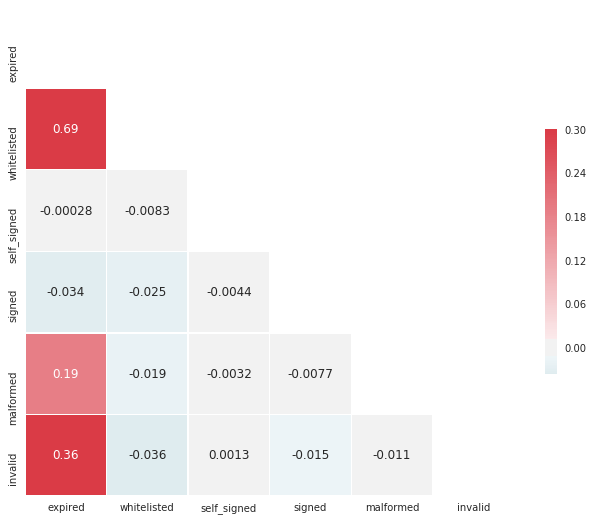

In [7]:
certi=pd.DataFrame(data=[cert_expired,cert_whitelisted,cert_self_signed,cert_signed,cert_malformed,cert_invalid])

certi=certi.transpose()
certi.reindex(index=["expired","whitelisted","self_signed","signed","malformed","invalid"])
corr=certi.corr()

sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True, vmax=.3, center=0,
            square=True,xticklabels=["expired","whitelisted","self_signed","signed","malformed","invalid"],yticklabels=["expired","whitelisted","self_signed","signed","malformed","invalid"], linewidths=.5, cbar_kws={"shrink": .5})


Crtanje heatmap korelacije između naknadno dodanih varijabli vezanih za karakteristike

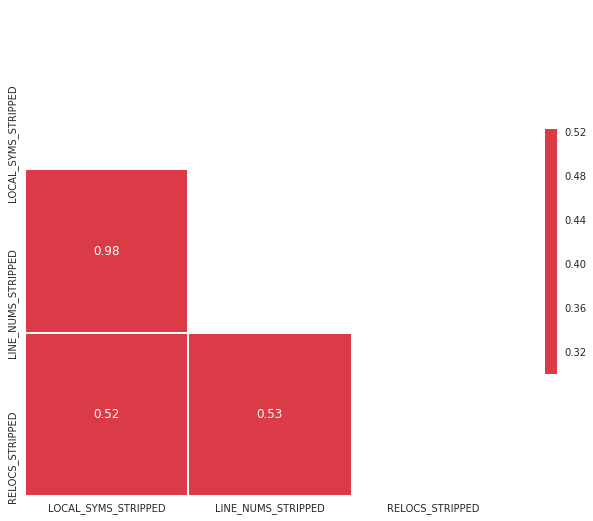

In [8]:
chara=pd.DataFrame(data=[IMAGE_FILE_LOCAL_SYMS_STRIPPED,IMAGE_FILE_LINE_NUMS_STRIPPED,IMAGE_FILE_RELOCS_STRIPPED])

chara=chara.transpose()
corr=chara.corr()

sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True, vmax=.3, center=0,
            square=True,xticklabels=["LOCAL_SYMS_STRIPPED","LINE_NUMS_STRIPPED","RELOCS_STRIPPED"],yticklabels=["LOCAL_SYMS_STRIPPED","LINE_NUMS_STRIPPED","RELOCS_STRIPPED"], linewidths=.5, cbar_kws={"shrink": .5})


Stvaranje dataframe sa svim podacima

In [109]:
data_df=pd.DataFrame.from_dict(data=Data,orient='index')
data_df=data_df.transpose()

Ispis podataka u .csv

In [24]:
data_df.to_csv("data.csv", sep='\t',index = False, encoding='utf-8')

Prikaz podataka

In [110]:

data_df

,sha,target,fileSize,fileEntropy,eCBLp,eCP,eCParHdr,eSS,eSP,eCsum,...,cert_self_signed,cert_signed,cert_malformed,cert_invalid,IMAGE_FILE_RELOCS_STRIPPED,IMAGE_FILE_LINE_NUMS_STRIPPED,IMAGE_FILE_LOCAL_SYMS_STRIPPED,txt,reloc,NO_NAME
0,000003cf1b52a990d99352da24aa73585b97647c,1,133856,6.19834,144,3,4,0,184,0,...,0,0,0,0,1,1,1,0,0,0
1,000007e5aa61eff1435edf63459d70a99441109d,0,45056,4.51184,144,3,4,0,184,0,...,0,0,0,0,0,1,1,0,1,0
2,000023255f375fb8397182833c8dd660fd760202,0,182784,5.58588,144,3,4,0,184,0,...,0,0,0,0,0,0,0,0,1,0
3,000023cf6df3479eef56dbdd5152382a9c22a4e8,0,22528,5.45382,144,3,4,0,184,0,...,0,0,0,0,0,0,0,0,1,0
4,0000379bd1ea62b8147bba528f1a186424ca43b3,1,364056,7.86368,144,3,4,0,184,0,...,0,0,0,0,1,0,0,0,0,0
5,000045c34059978f905862f0878b7e583c4f4561,1,106575,7.58654,144,3,4,0,184,0,...,0,0,0,0,0,1,0,0,0,0
6,00004a9067a95c6a85618aaa061f7af85abef948,1,175104,7.9498,80,2,4,0,184,0,...,0,0,0,0,1,1,1,0,0,0
7,000057e8d0be48f95181365c28dc9b0d25dd1771,0,15360,5.5397,144,3,4,0,184,0,...,0,0,0,0,0,0,0,0,1,0
8,0000618bda52300218d223f02e3323406d9e1640,0,35840,5.19023,144,3,4,0,184,0,...,0,0,0,0,1,1,1,0,0,0
9,00006234076ecb1fea4ee2df95f9470b00ca043c,0,75264,5.62125,144,3,4,0,184,0,...,0,0,0,0,0,0,0,0,1,0


RandomForest za odabir značajki koje će se koristiti u neuralnim mrežama

In [111]:
np.random.seed(0)
data_df1 = data_df.drop('section_names', axis=1)
data_df1['is_train'] = np.random.uniform(0, 1, len(data_df1)) <= .75
train, test = data_df1[data_df1['is_train']==True], data_df1[data_df1['is_train']==False]
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))
features = data_df1.columns[2:56]
y=train['target']
y=y.astype('int')
clf = RandomForestClassifier(n_estimators=1000, max_depth=20, n_jobs=-1, random_state=0, max_features=20, criterion='gini')
clf.fit(train[features], y)
preds=clf.predict(test[features])

Number of observations in the training data: 32880
Number of observations in the test data: 10904


Matrica konfuzije

In [112]:
conf_matrix=pd.crosstab(test['target'], preds, rownames=['Actual'], colnames=['Predicted'])
print(conf_matrix)

Predicted     0     1
Actual               
0          5481    16
1            42  5365


In [113]:
important_feature=sorted(list(zip(clf.feature_importances_, train[features])),reverse=True)
important_feature[0:30]

[(0.30583471483768826, 'max_entropy'),
 (0.16093477391559693, 'fileEntropy'),
 (0.13205575739345443, 'write'),
 (0.0701628407097889, 'tag_entropy'),
 (0.04898428628843629, 'IMAGE_FILE_RELOCS_STRIPPED'),
 (0.04750125322652355, 'max_section_size'),
 (0.04439184830716724, 'mean_section_size'),
 (0.034098258514758936, 'addressOfEntryPoint'),
 (0.02434458184408063, 'IMAGE_FILE_LINE_NUMS_STRIPPED'),
 (0.018904811938273088, 'majorLinkerVersion'),
 (0.014582129863127461, 'fileSize'),
 (0.009434833621212026, 'avg_entropy'),
 (0.009087260085237366, 'code'),
 (0.008365083827465276, 'execute'),
 (0.00707273324823697, 'sizeOfImage'),
 (0.007018653105426279, 'sizeOfCode'),
 (0.006542293616709051, 'eLFANew'),
 (0.006024577888950814, 'minorLinkerVersion'),
 (0.004964649905155557, 'sizeOfUninitializedData'),
 (0.004294499694192568, 'checksum'),
 (0.003656062499284743, 'no_of_section'),
 (0.003631272304483664, 'numberOfSections'),
 (0.003543939937061628, 'sizeOfInitializedData'),
 (0.003295011305666241,

Neuralne mreže: jedan skriveni sloj, broj neurona jednak broju input neurona

In [118]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.models import load_model   

In [70]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [87]:
# load dataset
variables_for_prediction=['target','max_entropy','fileEntropy','write','tag_entropy','IMAGE_FILE_RELOCS_STRIPPED',
                          'mean_section_size','max_section_size','addressOfEntryPoint','IMAGE_FILE_LINE_NUMS_STRIPPED',
                          'majorLinkerVersion','fileSize','avg_entropy','code','execute','sizeOfImage','sizeOfCode',
                          'eLFANew','minorLinkerVersion', 'sizeOfUninitializedData','checksum','no_of_section',
                          'sizeOfInitializedData','overlay','imageBase','codeview','len_api_list','eCBLp',
                          'sizeOfStackReserve','eCP','eCParHdr']
dataset =data_df1[variables_for_prediction]
dataset = dataset.values
# split into input (X) and output (Y) variables
X = dataset[:,1:31]
Y = dataset[:,0]

In [150]:
# baseline model
def create_model():
    # create model
    model = Sequential()
    init='normal'
    model.add(Dense(30, input_dim=30, kernel_initializer=init, activation='relu'))
    model.add(Dense(15, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
# Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [151]:
model = KerasClassifier(build_fn=create_model, verbose=0)
# grid search epochs, batch size
optimizers = 'adam'
initi = 'normal'
epochs = [30, 50, 100]
batches = [5, 10, 15]
param_grid = dict(epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.599329 using {'batch_size': 10, 'epochs': 50}
0.571761 (0.166324) with: {'batch_size': 5, 'epochs': 30}
0.330532 (0.063892) with: {'batch_size': 5, 'epochs': 50}
0.599306 (0.151421) with: {'batch_size': 5, 'epochs': 100}
0.330555 (0.063915) with: {'batch_size': 10, 'epochs': 30}
0.599329 (0.151445) with: {'batch_size': 10, 'epochs': 50}
0.502558 (0.180324) with: {'batch_size': 10, 'epochs': 100}
0.501576 (0.181073) with: {'batch_size': 15, 'epochs': 30}
0.330532 (0.063892) with: {'batch_size': 15, 'epochs': 50}
0.498401 (0.181105) with: {'batch_size': 15, 'epochs': 100}


In [156]:
# evaluate model for one set of parameters 
model = KerasClassifier(build_fn=create, epochs=50, batch_size=10, verbose=0)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
#print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Spremanje modela

In [159]:
model.fit(X,Y,epochs=50, batch_size=10, verbose=0)

AttributeError: 'KerasClassifier' object has no attribute 'to_json'

In [160]:
model_t=model

In [162]:
model_t.model.save('model_t.h5')